__Strategy Summary__

Enter a trade when:
- The model predicts a profitable mean reversion with P(class 1) > 0.7
- The residual magnitude > residual std (optional)
- If Residual > 0 → Spread is wide → expect it to **narrow** → SHORT Brent
- If Residual < 0 → Spread is tight → expect it to **widen** → LONG Brent
- Hold the trade for 10 days
- Profit = direction × (Spread_future - Spread_today)
- Win = if Profit ≥ $0.50


__Final Strategy__
1. Entry Condition:

The XGBoost model predicts a profitable reversion trade (class 1) with probability > 0.7

Optional filter: residual magnitude > residual std (to ignore weak edges)

2. Trade Direction:

If Residual > 0:
→ Short Brent, Long WTI
→ Expect the spread to narrow

If Residual < 0:
→ Long Brent, Short WTI
→ Expect the spread to widen

3. Entry Price Proxy:

Use the Brent-WTI spread on the entry day as the core metric

4. Exit Condition:

Time-based exit after exactly 10 trading days

5. Profit Calculation:

PnL = (Spread_exit - Spread_entry) × direction
(direction = -1 for short, +1 for long)

6. Trade is a Win if:

PnL ≥ $0.50

7. Evaluation Metrics:

Total number of trades taken
- Win rate
- Average return per trade
- Cumulative PnL
- Max drawdown 
- Sharpe ratio 


In [4]:
import pandas as pd
import numpy as np 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [5]:
import joblib

model = joblib.load('xgboost_model_v2.joblib')

df_model = pd.read_csv('df_model.csv')

feature_cols = [
    'Residual', 'Spread', 'Spread_RollingMean', 'Spread_RollingStd',
    'Residual_Mean', 'Residual_Std',
    'Residual_Z', 'Residual_Magnitude', 'Signal_Strength',
    'Trade_Direction', 'Price_Ratio'
]





__Time Structure(Rolling Windows)__
- Using a walk-forward (rolling) backtest

In [6]:
from xgboost import XGBClassifier

start_year = 2005
end_year = 2025

train_window = 7
test_window = 1
step_size = 1

results = []

for start in range(start_year, end_year - train_window - test_window + 1, step_size):
    train_start = f'{start}-01-01'
    train_end   = f'{start + train_window}-01-01'
    test_start  = f'{start + train_window}-01-01'
    test_end    = f'{start + train_window + test_window}-01-01'

    # Create train/test masks
    train_mask = (df_model['Date'] >= train_start) & (df_model['Date'] < train_end)
    test_mask  = (df_model['Date'] >= test_start) & (df_model['Date'] < test_end)

    # Drop missing values in this train/test window
    train_df = df_model.loc[train_mask].dropna(subset=feature_cols + ['Profit_Signal_10'])
    test_df  = df_model.loc[test_mask].dropna(subset=feature_cols + ['Profit_Signal_10'])

    X_train = train_df[feature_cols]
    y_train = train_df['Profit_Signal_10']

    X_test = test_df[feature_cols]
    y_test = test_df['Profit_Signal_10']

    # Skip if no data
    if X_train.shape[0] == 0 or y_train.shape[0] == 0:
        continue

    # Train the model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Predict probabilities
    proba = model.predict_proba(X_test)[:, 1]  # Confidence for class=1
    confident_preds = proba >= 0.7  # Apply threshold

    # Log results
    results.append({
        'train_period': f'{train_start} to {train_end}',
        'test_period': f'{test_start} to {test_end}',
        'n_trades': int(confident_preds.sum()),
        'avg_confidence': proba[confident_preds].mean() if confident_preds.sum() > 0 else 0
    })

results
    


c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:00] WARNING: C:\actio

[{'train_period': '2005-01-01 to 2012-01-01',
  'test_period': '2012-01-01 to 2013-01-01',
  'n_trades': 30,
  'avg_confidence': np.float32(0.9027246)},
 {'train_period': '2006-01-01 to 2013-01-01',
  'test_period': '2013-01-01 to 2014-01-01',
  'n_trades': 23,
  'avg_confidence': np.float32(0.8592794)},
 {'train_period': '2007-01-01 to 2014-01-01',
  'test_period': '2014-01-01 to 2015-01-01',
  'n_trades': 59,
  'avg_confidence': np.float32(0.82546854)},
 {'train_period': '2008-01-01 to 2015-01-01',
  'test_period': '2015-01-01 to 2016-01-01',
  'n_trades': 70,
  'avg_confidence': np.float32(0.85594815)},
 {'train_period': '2009-01-01 to 2016-01-01',
  'test_period': '2016-01-01 to 2017-01-01',
  'n_trades': 88,
  'avg_confidence': np.float32(0.82413083)},
 {'train_period': '2010-01-01 to 2017-01-01',
  'test_period': '2017-01-01 to 2018-01-01',
  'n_trades': 109,
  'avg_confidence': np.float32(0.9041621)},
 {'train_period': '2011-01-01 to 2018-01-01',
  'test_period': '2018-01-01 to 

In [7]:

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
results_df

,train_period,test_period,n_trades,avg_confidence
0,2005-01-01 to 2012-01-01,2012-01-01 to 2013-01-01,30,0.902725
1,2006-01-01 to 2013-01-01,2013-01-01 to 2014-01-01,23,0.859279
2,2007-01-01 to 2014-01-01,2014-01-01 to 2015-01-01,59,0.825469
3,2008-01-01 to 2015-01-01,2015-01-01 to 2016-01-01,70,0.855948
4,2009-01-01 to 2016-01-01,2016-01-01 to 2017-01-01,88,0.824131
5,2010-01-01 to 2017-01-01,2017-01-01 to 2018-01-01,109,0.904162
6,2011-01-01 to 2018-01-01,2018-01-01 to 2019-01-01,75,0.851973
7,2012-01-01 to 2019-01-01,2019-01-01 to 2020-01-01,112,0.899746
8,2013-01-01 to 2020-01-01,2020-01-01 to 2021-01-01,49,0.891625
9,2014-01-01 to 2021-01-01,2021-01-01 to 2022-01-01,31,0.869714


__Phase 1: Simulate Each Trades PnL__
- Identify Entry Points
- Fetch Exit Prices
- Compute Profit Per Trade
- Filter by Profit Threshold

In [8]:



def collect_signals(
    df: pd.DataFrame,
    date_col: str = "Date",
    spread_col: str = "Spread",
    residual_col: str = "Residual",
    residual_std_col: str = "Residual_Std",
    prob_col: str = "Predicted_Prob",
    prob_thresh: float = 0.7,
    require_strong_residual: bool = True
) -> pd.DataFrame:
    """
    Phase 1: Identify and collect high-confidence trade signals.
    
    Parameters
    ----------
    df : pd.DataFrame
        Test set containing at least the Date, Spread, Residual, Residual_Std, and Predicted_Prob columns.
    date_col : str
        Name of the column with the timestamp for each row.
    spread_col : str
        Name of the column with the spread value.
    residual_col : str
        Name of the column with your models residual.
    residual_std_col : str
        Name of the column with the residuals standard deviation.
    prob_col : str
        Name of the column with the models predicted probability for class 1.
    prob_thresh : float
        Minimum probability required to consider a signal “high-confidence.”
    require_strong_residual : bool
        If True, also filter for |Residual| > Residual_Std.
    
    Returns
    -------
    pd.DataFrame
        “Potential trades” table with columns:
        [Entry_Date, Entry_Spread, Residual, Predicted_Prob, Direction]
    """
    # 1. Copy & parse dates
    df_signals = df.copy()
    df_signals[date_col] = pd.to_datetime(df_signals[date_col])

    #2. Build Boolean mask for high confidence
    mask = df_signals[prob_col] > prob_thresh
    if require_strong_residual and residual_std_col in df_signals.columns:
        mask &= df_signals[residual_col].abs() > df_signals[residual_std_col]
    
    #3. Filter and select only needed columns
    signals = df_signals.loc[
        mask,
        [date_col, spread_col, residual_col, prob_col]
    ].copy()

    #Determine trade direction
    signals["Direction"] = np.where(signals[residual_col] < 0, 'Long', 'Short')

    #5. Rename columns for simplicity
    signals = signals.rename(columns={
        date_col: "Entry_Date",
        spread_col: "Entry_Spread",
        prob_col: "Predicted_Prob"
    })

    return signals.reset_index(drop=True)
                             
import numpy as np
import pandas as pd

# 1) Compute predicted probabilities for your test set
#    (model is what uploaded via joblib.load)
probs = model.predict_proba(X_test)[:, 1]

# 2) Build your test DataFrame aligned to X_test
test_df = df_model.iloc[X_test.index].copy()
test_df['Predicted_Prob'] = probs

# 3) Now collect Phase-1 signals
potential_trades_df = collect_signals(
    df=test_df,
    prob_thresh=0.7,
    require_strong_residual=True
)

# 4) Inspect the first few signals
potential_trades_df.head(100)



,Entry_Date,Entry_Spread,Residual,Predicted_Prob,Direction
0,2024-02-05,6.09,1.591065,0.804189,Short
1,2024-02-08,6.34,1.542239,0.750094,Short
2,2024-03-13,3.28,-1.863226,0.863076,Long
3,2024-03-14,4.00,-1.271911,0.875124,Long
4,2024-03-15,3.45,-1.802911,0.967790,Long
5,2024-03-18,2.79,-2.613188,0.987872,Long
6,2024-03-19,2.97,-2.494508,0.992438,Long
7,2024-03-20,2.98,-2.346322,0.973710,Long
8,2024-03-21,2.93,-2.327229,0.972444,Long
9,2024-03-25,3.77,-1.523503,0.843484,Long


__Phase 2 - Fetch the Exit Prices (10-day horizon)__

In [9]:
import pandas as pd

def fetch_exits(
    potential_trades_df: pd.DataFrame,
    full_price_df: pd.DataFrame,
    hold_days: int = 10
) -> pd.DataFrame:
    """
    Phase 2: For each entry in potential_trades_df, look hold_days ahead
    in full_price_df and fetch the exit spread and date.
    """
    # 1. Prepare the price DataFrame
    fp = full_price_df.copy()
    fp['Date'] = pd.to_datetime(fp['Date'])
    fp = fp.sort_values('Date').reset_index(drop=True)
    
    # 2. Build a mapping from Date → integer index
    date_to_idx = {d: i for i, d in enumerate(fp['Date'])}
    
    exit_records = []
    
    # 3. Loop through each potential trade
    for _, trade in potential_trades_df.iterrows():
        entry_date   = pd.to_datetime(trade['Entry_Date'])
        entry_spread = trade['Entry_Spread']
        residual     = trade['Residual']
        prob         = trade['Predicted_Prob']
        direction    = trade['Direction']
        
        # A) get index of entry_date via dict.get()
        idx = date_to_idx.get(entry_date)
        if idx is None:
            continue  # entry date not in price data
        
        # B) compute exit index
        exit_idx = idx + hold_days
        if exit_idx >= len(fp):
            continue  # no data that far ahead
        
        # C) fetch exit row
        exit_row    = fp.iloc[exit_idx]
        exit_date   = exit_row['Date']
        exit_spread = exit_row['Spread']
        
        # D) record fields
        exit_records.append({
            'Entry_Date'    : entry_date,
            'Exit_Date'     : exit_date,
            'Entry_Spread'  : entry_spread,
            'Exit_Spread'   : exit_spread,
            'Residual'      : residual,
            'Predicted_Prob': prob,
            'Direction'     : direction
        })
    
    # 4. Convert to DataFrame and return
    exits_df = pd.DataFrame(exit_records)
    return exits_df

# --- USAGE ---
exits_df = fetch_exits(
    potential_trades_df=potential_trades_df,
    full_price_df=df_model[['Date','Spread']],
    hold_days=10
)

exits_df.head()





,Entry_Date,Exit_Date,Entry_Spread,Exit_Spread,Residual,Predicted_Prob,Direction
0,2024-02-05,2024-02-21,6.09,5.88,1.591065,0.804189,Short
1,2024-02-08,2024-02-23,6.34,6.58,1.542239,0.750094,Short
2,2024-03-13,2024-03-27,3.28,2.79,-1.863226,0.863076,Long
3,2024-03-14,2024-03-28,4.00,2.21,-1.271911,0.875124,Long
4,2024-03-15,2024-04-02,3.45,1.68,-1.802911,0.967790,Long


__Phase 3: Calculate Profit Per Trade__

In [10]:
# Empty list to collect each trade's PnL
profit_records = []

#Loop through exits table
for i, row in exits_df.iterrows():
    #fetch entry and exit spreads
    entry_spread = row["Entry_Spread"]
    exit_spread = row['Exit_Spread']

    #Deterine direction sign
    direction = row['Direction'] #Should be 'long' or 'short'
    direction_sign = 1 if direction == 'Long' else -1

    #Compute PnL in spread units
    PnL = (exit_spread - entry_spread) * direction_sign

    #Define profit target for a winning trade
    profit_target = 0.2
    win = 1 if PnL >= profit_target else 0

    # E) Record everything
    profit_records.append({
        'Entry_Date'   : row['Entry_Date'],
        'Exit_Date'    : row['Exit_Date'],
        'Entry_Spread' : entry_spread,
        'Exit_Spread'  : exit_spread,
        'Direction'    : direction,
        'PnL'          : PnL,
        'Win'          : win
    })

# 3. Convert the list of dicts into a DataFrame
trades_df = pd.DataFrame(profit_records)

#pd.set_option('display.max_rows', None)
#trades_df

trades_df.head()

#print(trades_df['Win'].sum())





,Entry_Date,Exit_Date,Entry_Spread,Exit_Spread,Direction,PnL,Win
0,2024-02-05,2024-02-21,6.09,5.88,Short,0.21,1
1,2024-02-08,2024-02-23,6.34,6.58,Short,-0.24,0
2,2024-03-13,2024-03-27,3.28,2.79,Long,-0.49,0
3,2024-03-14,2024-03-28,4.00,2.21,Long,-1.79,0
4,2024-03-15,2024-04-02,3.45,1.68,Long,-1.77,0


__Phase 4: Filter Trades by Profit Threshold__

In [23]:
#Add Win and Loss columns
profit_target = 0.3
trades_df["Win"] = (trades_df["PnL"] >= profit_target).astype(int)
trades_df['Loss'] = 1 - trades_df["Win"]

#Basic Counts
total = len(trades_df)
wins = trades_df.Win.sum()
win_rate = wins / total

# Average win/loss
#Average win size - Mean of PnL values only for winning trades
average_win = trades_df.loc[trades_df.Win == 1, 'PnL'].mean() 
#Average loss size - Mean of PnL values only for losing trades(will be negative)
average_loss = trades_df.loc[trades_df.Win == 0, 'PnL'].mean()

#Profit Factor and expectancy
profit_factor = trades_df.loc[trades_df.Win == 1, 'PnL'].sum() / abs(trades_df.loc[trades_df.Win==0, 'PnL'].sum())
expectancy = win_rate * average_win + (1-win_rate) * average_loss

#Sharpe - risk adjusted return per trade (higher the better)
sharpe = trades_df.PnL.mean() / trades_df.PnL.std()

#Draw Down 
# Cumalative PnL Curve - Running total of PnL over each successive trade
cumulative = trades_df.PnL.cumsum()
# Max Drawdown - Largest peak to trough drop in the curve
max_dd = (cumulative.cummax() - cumulative).max()

#Summary dict
summary = {
  'Total Trades': total,
  'Win Rate (%)': round(win_rate*100,2),
  'Avg Win': round(average_win,2),
  'Avg Loss': round(average_loss,2),
  'Profit Factor': round(profit_factor,2),
  'Expectancy': round(expectancy,2),
  'Sharpe Ratio': round(sharpe,2),
  'Max Drawdown': round(max_dd,2)
}

summary

print('\n' + "Strategy Summary ".center(40, "="))
for name, val in summary.items():
    #add % sign for rates/drawdowns
    if "Rate" in name or "Drawdown" in name:
        print(f"{name:20s} : {val:6.2f}%")
    else:
        print(f"{name:20s} : {val:6.2f}")
print("="*40 + "\n")


===========Strategy Summary ============
Total Trades         :  74.00
Win Rate (%)         :  63.51%
Avg Win              :   1.75
Avg Loss             :  -0.89
Profit Factor        :   3.42
Expectancy           :   0.79
Sharpe Ratio         :   0.47
Max Drawdown         :  16.95%



__Phase 5: Build Full Trade Log__

In [50]:
trade_logs = []
profit_target = 0.5

for i, row in exits_df.iterrows():
    """
    firstly tuple unpacking takes (index, row_series)
    Each iteration returns a tuple where,
    index is the original DataFrame index of the row and row_series contains all the column value-pairs for that row
    """
    entry_date = row["Entry_Date"]
    exit_date = row["Exit_Date"]
    direction = row["Direction"]
    prob = row['Predicted_Prob']
    entry_spread = row['Entry_Spread']
    exit_spread = row["Exit_Spread"]

    #Compute PnL using +1 for long and -1 for short
    PnL = (exit_spread - entry_spread) * (1 if direction == 'Long' else -1)
   # set Win flag, but do not gate your append on it
    win = 1 if PnL >= profit_target else 0


    trade_logs.append({
        'Entry_Date'    : entry_date,
        'Exit_Date'     : exit_date,
        'Direction'     : direction,
        'Predicted_Prob': prob,
        'Entry_Spread'  : entry_spread,
        'Exit_Spread'   : exit_spread,
        'PnL'           : PnL,
        'Win'           : win
    })
    


trade_logs_df = pd.DataFrame(trade_logs)

trade_logs_df.head()




,Entry_Date,Exit_Date,Direction,Predicted_Prob,Entry_Spread,Exit_Spread,PnL,Win
0,2024-02-05,2024-02-21,Short,0.804189,6.09,5.88,0.21,0
1,2024-02-08,2024-02-23,Short,0.750094,6.34,6.58,-0.24,0
2,2024-03-13,2024-03-27,Long,0.863076,3.28,2.79,-0.49,0
3,2024-03-14,2024-03-28,Long,0.875124,4.00,2.21,-1.79,0
4,2024-03-15,2024-04-02,Long,0.967790,3.45,1.68,-1.77,0


__Phase 6: Analyze Strategy Performance__

In [55]:


def analyze_performance(trades_df, profit_target=0.5):
    import numpy as np
    
    # Ensure sorted by exit date
    df = trades_df.sort_values('Exit_Date').reset_index(drop=True)
    
    total_trades = len(df)
    wins         = df['Win'].sum()
    win_rate     = wins / total_trades if total_trades else 0
    
    pnl_series   = df['PnL']
    avg_profit   = pnl_series.mean()
    cum_pnl      = pnl_series.cumsum()
    max_dd       = (cum_pnl.cummax() - cum_pnl).max()
    
    sharpe       = avg_profit / pnl_series.std() if pnl_series.std() else 0
    
    return {
      'Total Trades':           total_trades,
      'Win Rate (%)':           round(win_rate*100, 2),
      'Average Profit per Trade': round(avg_profit, 2),
      'Cumulative PnL':         round(cum_pnl.iloc[-1], 2),
      'Max Drawdown':           round(max_dd, 2),
      'Sharpe Ratio':           round(sharpe, 2)
    }

# Usage:
performance_df = pd.DataFrame.from_dict(perf, orient='index', columns=['Value'])
performance_df.index.name = 'Metric'
print(performance_df)







                          Value
Metric                         
Total Trades              74.00
Win Rate (%)              63.51
Average Profit per Trade   0.79
Cumulative PnL            58.29
Max Drawdown              16.95
Sharpe Ratio               0.47


__Phase 7: Visualize the Strategy__

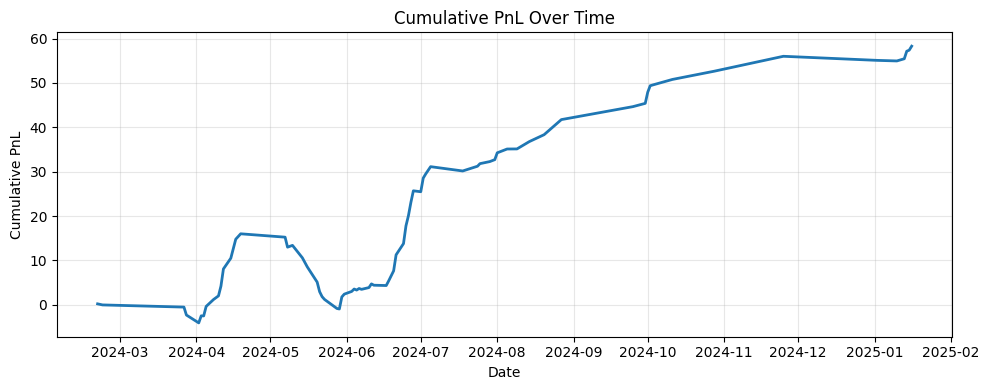

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dates are datetime and sorted
trades_df['Exit_Date'] = pd.to_datetime(trades_df['Exit_Date'])
trades_df = trades_df.sort_values('Exit_Date').reset_index(drop=True)

# 1) cumulative PnL
trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()

# 2) drawdown series
cum = trades_df['Cumulative_PnL']
high_water = cum.cummax()
trades_df['Drawdown'] = high_water - cum


plt.figure(figsize=(10,4))
plt.plot(trades_df['Exit_Date'], trades_df['Cumulative_PnL'], lw=2)
plt.title("Cumulative PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



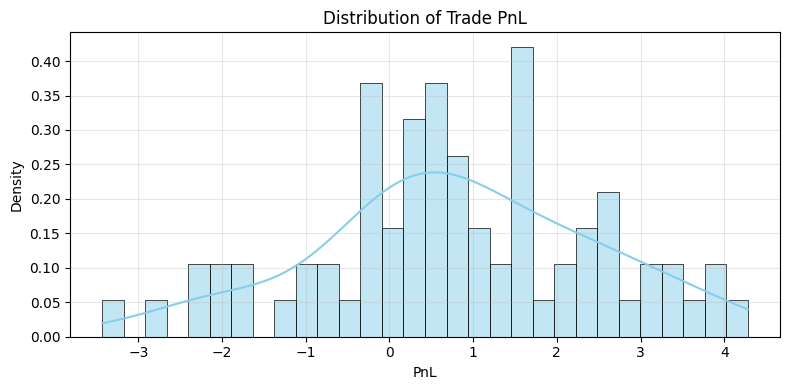

In [58]:
plt.figure(figsize=(8,4))
sns.histplot(trades_df['PnL'], bins=30, stat='density', kde=True,
             color='skyblue', edgecolor='black', linewidth=0.5)
plt.title("Distribution of Trade PnL")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


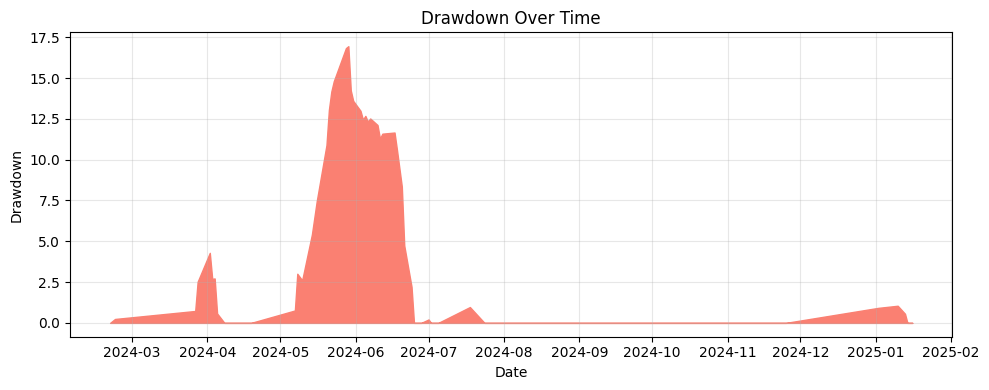

In [59]:
plt.figure(figsize=(10,4))
plt.fill_between(trades_df['Exit_Date'], trades_df['Drawdown'], color='salmon')
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [71]:
%matplotlib inline

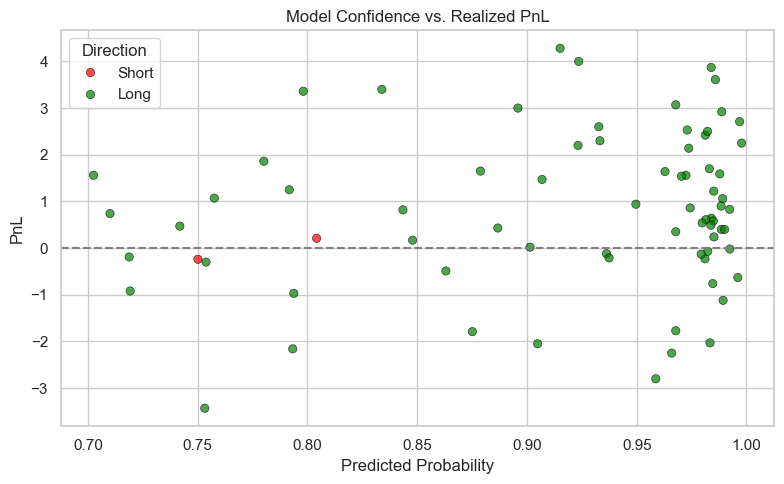

In [72]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=trades_df,
    x='Predicted_Prob',
    y='PnL',
    hue='Direction',
    palette={'Long':'green', 'Short':'red'},
    edgecolor='black',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Model Confidence vs. Realized PnL")
plt.xlabel("Predicted Probability")
plt.ylabel("PnL")
plt.legend(title='Direction')
plt.tight_layout()
plt.show()
